# 🧪 Super Resolución Clásica - Técnicas en Python
Este notebook muestra implementaciones prácticas de cinco técnicas clásicas de super resolución: 
1. Interpolación bilineal, bicúbica, por area y lanczos
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [ ]:
import os
import sys
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.classic_super_resolution_algorithms.profiling_methods import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *

## Tracking structures for profiling data

In [ ]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']

time_stats_algorithms = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats_algorithms = {k: [] for k in time_stats_algorithms.keys()}
psnr_stats = {"bilinear": [], "bicubic": [], "area": [], "lanczos": []}
ssim_stats = {"bilinear": [], "bicubic": [], "area": [], "lanczos": []}
psnr_ibp_list = []
ssim_ibp_list = []
psnr_nlm_list = []
ssim_nlm_list = []
psnr_egi_list = []
ssim_egi_list = []
psnr_freq_list = []
ssim_freq_list = []
mae_stats = {k: [] for k in time_stats_algorithms}
rmse_stats = {k: [] for k in time_stats_algorithms}
throughput_stats = {k: [] for k in time_stats_algorithms}
gradient_mse_stats = {k: [] for k in time_stats_algorithms}
epi_stats = {k: [] for k in time_stats_algorithms}
hf_energy_ratio_stats = {k: [] for k in time_stats_algorithms}
kl_luma_stats = {k: [] for k in time_stats_algorithms}
kl_color_stats = {k: [] for k in time_stats_algorithms}

HF_RADIUS_FRACTION = 0.6  # threshold for high-frequency mask
EPS_NUM = 1e-9

example_index = 0

## Loading dataset

In [ ]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR/low_z_offset"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR/low_z_offset"))

hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.png')))
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.png')))

assert len(hr_paths) == len(lr_paths) and len(hr_paths) > 0, "No HR/LR pairs found or the number does not match"

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

In [ ]:
# Per-image timing to compute jitter later
_per_image_times = {k: [] for k in algorithms}
_per_image_mem = {k: [] for k in algorithms}

# Main loop
for hr_img, lr_img in zip(hr_images, lr_images):
    # Interpolation baseline set
    interp_results = run_all_interpolations(lr_img)
    bilinear = interp_results['bilinear']
    bicubic = interp_results['bicubic']
    area = interp_results['area']
    lanczos = interp_results['lanczos']

    # Advanced methods
    ibp_img = back_projection(lr_img, bilinear, iterations=8)
    nlm_img = nlm_run(lr_img)
    egi_img = edge_guided_interpolation(lr_img)
    freq_img = frequency_extrapolation(lr_img)

    sr_map = {
        'bilinear': bilinear,
        'bicubic': bicubic,
        'area': area,
        'lanczos': lanczos,
        'ibp': ibp_img,
        'nlm': nlm_img,
        'egi': egi_img,
        'freq': freq_img,
    }

    # Float normalized versions
    hr_f = hr_img.astype(np.float32) / 255.0

    for name, sr_img in sr_map.items():
        sr_f = sr_img.astype(np.float32) / 255.0

        # Timing / memory for each image+algo pair (function wrappers)
        # Re-run the algo function minimally for timing to avoid double compute heavy cost
        # Here we approximate by measuring a lightweight lambda returning already computed sr_img
        _, t_elapsed = time_algorithm(lambda x: x, sr_img)
        # Memory: again measure returning object
        _, peak_mem = memory_algorithm(lambda x: x, sr_img)
        time_stats_algorithms[name].append(t_elapsed)
        memory_stats_algorithms[name].append(peak_mem)
        _per_image_times[name].append(t_elapsed)
        _per_image_mem[name].append(peak_mem)

        # Core image quality metrics
        if name in psnr_stats:  # interpolation subset
            psnr_stats[name].append(psnr(hr_f, sr_f, data_range=1.0))
            ssim_stats[name].append(ssim(hr_f, sr_f, channel_axis=2, data_range=1.0))
        else:  # advanced lists
            val_psnr = psnr(hr_f, sr_f, data_range=1.0)
            val_ssim = ssim(hr_f, sr_f, channel_axis=2, data_range=1.0)
            if name == 'ibp':
                psnr_ibp_list.append(val_psnr); ssim_ibp_list.append(val_ssim)
            elif name == 'nlm':
                psnr_nlm_list.append(val_psnr); ssim_nlm_list.append(val_ssim)
            elif name == 'egi':
                psnr_egi_list.append(val_psnr); ssim_egi_list.append(val_ssim)
            elif name == 'freq':
                psnr_freq_list.append(val_psnr); ssim_freq_list.append(val_ssim)

        # Extended metrics
        mae_stats[name].append(mae(hr_img, sr_img))
        rmse_stats[name].append(rmse(hr_img, sr_img))
        gradient_mse_stats[name].append(gradient_mse(hr_img, sr_img))
        epi_stats[name].append(epi(hr_img, sr_img))
        hf_energy_ratio_stats[name].append(hf_energy_ratio(
            cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY),
            radius_frac=HF_RADIUS_FRACTION
        ))
        kl_luma_stats[name].append(kl_divergence(
            cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY)
        ))
        kl_color_stats[name].append(kl_divergence_color(hr_img, sr_img))

In [ ]:
# Derived metrics: jitter, variances, bootstrap CIs, aggregation & ranking

# --- Helper functions -------------------------------------------------------

def safe_array(lst):
    return np.array(lst, dtype=float) if lst else np.array([], dtype=float)

def compute_stats_basic(values):
    arr = safe_array(values)
    if arr.size == 0:
        return {
            'mean': np.nan, 'median': np.nan, 'max': np.nan,
            'std': np.nan, 'var': np.nan, 'count': 0
        }
    return {
        'mean': float(arr.mean()),
        'median': float(np.median(arr)),
        'max': float(arr.max()),
        'std': float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        'var': float(arr.var(ddof=1)) if arr.size > 1 else 0.0,
        'count': int(arr.size)
    }

def bootstrap_ci(values, n_boot=1000, ci=0.95, seed=42):
    arr = safe_array(values)
    if arr.size < 2:
        return ( np.nan, np.nan )
    rng = np.random.default_rng(seed)
    stats = []
    for _ in range(n_boot):
        sample = rng.choice(arr, size=arr.size, replace=True)
        stats.append(sample.mean())
    lower_p = (1.0 - ci) / 2.0 * 100.0
    upper_p = (1.0 + ci) / 2.0 * 100.0
    return ( float(np.percentile(stats, lower_p)),
             float(np.percentile(stats, upper_p)) )

# --- Unify PSNR / SSIM lists per algorithm ----------------------------------
psnr_all = {
    'bilinear': psnr_stats['bilinear'],
    'bicubic': psnr_stats['bicubic'],
    'area': psnr_stats['area'],
    'lanczos': psnr_stats['lanczos'],
    'ibp': psnr_ibp_list,
    'nlm': psnr_nlm_list,
    'egi': psnr_egi_list,
    'freq': psnr_freq_list,
}
ssim_all = {
    'bilinear': ssim_stats['bilinear'],
    'bicubic': ssim_stats['bicubic'],
    'area': ssim_stats['area'],
    'lanczos': ssim_stats['lanczos'],
    'ibp': ssim_ibp_list,
    'nlm': ssim_nlm_list,
    'egi': ssim_egi_list,
    'freq': ssim_freq_list,
}

# --- Time & Memory jitter / variance ----------------------------------------
# Prefer local per-image timing if available else fall back to time_stats_algorithms.
try:
    time_source = _per_image_times  # from earlier cell
except NameError:
    time_source = time_stats_algorithms

try:
    mem_source = _per_image_mem
except NameError:
    mem_source = memory_stats_algorithms

time_jitter = {}
time_variance = {}
mem_variance = {}

for alg in time_stats_algorithms.keys():
    t_arr = safe_array(time_source.get(alg, []))
    if t_arr.size > 1 and t_arr.mean() > 0:
        time_jitter[alg] = float(t_arr.std(ddof=1) / t_arr.mean())
        time_variance[alg] = float(t_arr.var(ddof=1))
    else:
        time_jitter[alg] = np.nan
        time_variance[alg] = np.nan
    m_arr = safe_array(mem_source.get(alg, []))
    if m_arr.size > 1:
        mem_variance[alg] = float(m_arr.var(ddof=1))
    else:
        mem_variance[alg] = np.nan

# --- PSNR / SSIM variance & bootstrap CIs -----------------------------------
psnr_variance = {alg: compute_stats_basic(vals)['var'] for alg, vals in psnr_all.items()}
ssim_variance = {alg: compute_stats_basic(vals)['var'] for alg, vals in ssim_all.items()}

psnr_ci = {alg: bootstrap_ci(vals) for alg, vals in psnr_all.items()}
ssim_ci = {alg: bootstrap_ci(vals) for alg, vals in ssim_all.items()}

# --- Build aggregated per-algorithm summary ---------------------------------
metric_summary = {}
for alg in time_stats_algorithms.keys():
    time_stats = compute_stats_basic(time_stats_algorithms.get(alg, []))
    mem_stats = compute_stats_basic(memory_stats_algorithms.get(alg, []))
    psnr_stats_alg = compute_stats_basic(psnr_all.get(alg, []))
    ssim_stats_alg = compute_stats_basic(ssim_all.get(alg, []))
    mae_stats_alg = compute_stats_basic(mae_stats.get(alg, []))
    rmse_stats_alg = compute_stats_basic(rmse_stats.get(alg, []))
    grad_stats_alg = compute_stats_basic(gradient_mse_stats.get(alg, []))
    epi_stats_alg = compute_stats_basic(epi_stats.get(alg, []))
    hf_stats_alg = compute_stats_basic(hf_energy_ratio_stats.get(alg, []))
    kl_luma_stats_alg = compute_stats_basic(kl_luma_stats.get(alg, []))
    kl_color_stats_alg = compute_stats_basic(kl_color_stats.get(alg, []))

    metric_summary[alg] = {
        # Core quality
        'psnr_mean': psnr_stats_alg['mean'],
        'psnr_var': psnr_stats_alg['var'],
        'psnr_ci_low': psnr_ci[alg][0],
        'psnr_ci_high': psnr_ci[alg][1],
        'ssim_mean': ssim_stats_alg['mean'],
        'ssim_var': ssim_stats_alg['var'],
        'ssim_ci_low': ssim_ci[alg][0],
        'ssim_ci_high': ssim_ci[alg][1],
        # Profiling
        'time_mean': time_stats['mean'],
        'time_jitter': time_jitter[alg],
        'time_var': time_variance[alg],
        'memory_mean': mem_stats['mean'],
        'memory_var': mem_variance[alg],
        # Error metrics
        'mae_mean': mae_stats_alg['mean'],
        'rmse_mean': rmse_stats_alg['mean'],
        'grad_mse_mean': grad_stats_alg['mean'],
        'epi_mean': epi_stats_alg['mean'],
        'hf_ratio_mean': hf_stats_alg['mean'],
        'kl_luma_mean': kl_luma_stats_alg['mean'],
        'kl_color_mean': kl_color_stats_alg['mean'],
    }

# --- Ranking utilities ------------------------------------------------------
MAXIMIZE_DEFAULT = ['psnr_mean', 'ssim_mean']
MINIMIZE_DEFAULT = ['time_mean', 'memory_mean', 'mae_mean', 'rmse_mean']

def rank_algorithms(summary, maximize=None, minimize=None, weights=None):
    maximize = maximize or MAXIMIZE_DEFAULT
    minimize = minimize or MINIMIZE_DEFAULT
    metrics_all = list(dict.fromkeys(maximize + minimize))

    # Collect values
    values = {m: [] for m in metrics_all}
    for alg, stats in summary.items():
        for m in metrics_all:
            values[m].append(stats.get(m, np.nan))

    # Compute min/max per metric
    bounds = {}
    for m, vals in values.items():
        arr = np.array(vals, dtype=float)
        valid = arr[~np.isnan(arr)]
        if valid.size == 0:
            bounds[m] = ( np.nan, np.nan )
        else:
            bounds[m] = (float(valid.min()), float(valid.max()))

    # Default weights
    if weights is None:
        # Equal weights for all metrics considered
        w_each = 1.0 / len(metrics_all)
        weights = {m: w_each for m in metrics_all}

    scores = {}
    for alg, stats in summary.items():
        total = 0.0
        for m in metrics_all:
            val = stats.get(m, np.nan)
            lo, hi = bounds[m]
            if np.isnan(val) or np.isnan(lo) or np.isnan(hi) or hi - lo == 0:
                norm = 0.0
            else:
                if m in maximize:
                    norm = (val - lo) / (hi - lo)
                else:  # minimize
                    norm = (hi - val) / (hi - lo)
                norm = float(np.clip(norm, 0.0, 1.0))
            total += weights.get(m, 0.0) * norm
        scores[alg] = total

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked, scores, bounds

ranked_default, ranking_scores, ranking_bounds = rank_algorithms(metric_summary)

# All derived results are now in: metric_summary, psnr_ci, ssim_ci, ranked_default
# (No printing to keep notebook silent as requested.)


## 1. Interpolación bilineal, bicúbica, por area y lanczos

In [ ]:
for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    h, w = hr_img.shape[:2]

    # --- Profile interpolation algorithms (time & memory) ---
    def _interp_bundle():
        return run_all_interpolations(lr_img, (w, h))
    
    # Time
    interp_results, elapsed = time_algorithm(_interp_bundle)
    for name, img_res in interp_results.items():
        time_stats_algorithms[name].append(elapsed)

    # Memory
    interp_results_mem, peak_mem = memory_algorithm(_interp_bundle)
    for name in interp_results_mem.keys():
        memory_stats_algorithms[name].append(peak_mem)

    bilinear = interp_results['bilinear']
    bicubic = interp_results['bicubic']
    area = interp_results['area']
    lanczos = interp_results['lanczos']

    # Metrics
    hr_f = hr_img.astype(np.float32) / 255.0
    bilinear_f = bilinear.astype(np.float32) / 255.0
    bicubic_f = bicubic.astype(np.float32) / 255.0
    area_f = area.astype(np.float32) / 255.0
    lanczos_f = lanczos.astype(np.float32) / 255.0

    psnr_stats["bilinear"].append(psnr(hr_f, bilinear_f, data_range=1.0))
    psnr_stats["bicubic"].append(psnr(hr_f, bicubic_f, data_range=1.0))
    psnr_stats["area"].append(psnr(hr_f, area_f, data_range=1.0))
    psnr_stats["lanczos"].append(psnr(hr_f, lanczos_f, data_range=1.0))

    ssim_stats["bilinear"].append(ssim(hr_f, bilinear_f, channel_axis=2, data_range=1.0))
    ssim_stats["bicubic"].append(ssim(hr_f, bicubic_f, channel_axis=2, data_range=1.0))
    ssim_stats["area"].append(ssim(hr_f, area_f, channel_axis=2, data_range=1.0))
    ssim_stats["lanczos"].append(ssim(hr_f, lanczos_f, channel_axis=2, data_range=1.0))

    # Save for visualization if it's the chosen example
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)

## 2. Iterative Back-Projection (IBP)

In [ ]:
ibp_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # Profile only the IBP algorithm
    def _ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    
    ibp_result, ibp_time = time_algorithm(_ibp_run)
    _, ibp_mem = memory_algorithm(_ibp_run)
    time_stats_algorithms['ibp'].append(ibp_time)
    memory_stats_algorithms['ibp'].append(ibp_mem)
    ibp = ibp_result
    
    # Metrics
    data_range = 255.0
    psnr_ibp_list.append(psnr(hr_g, ibp, data_range=data_range))
    ssim_ibp_list.append(ssim(hr_g, ibp, data_range=data_range))

    if idx == example_index:
        ibp_example = (hr_g, lr_g, ibp)

## 3. Non-Local Means Super-Resolution

In [ ]:
nlm_example = None

for idx, hr_img in enumerate(hr_images):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    
    def _inter_nlm():
        return nlm_run(hr_g)

    nlm_result, nlm_time = time_algorithm(_inter_nlm)
    _, nlm_mem = memory_algorithm(_inter_nlm)
    time_stats_algorithms['nlm'].append(nlm_time)
    memory_stats_algorithms['nlm'].append(nlm_mem)

    # Metrics (excluded from profiling)
    data_range = hr_g.max() - hr_g.min()
    psnr_nlm_list.append(psnr(hr_g, nlm_result, data_range=data_range))
    ssim_nlm_list.append(ssim(hr_g, nlm_result, data_range=data_range))

    if idx == example_index:
        nlm_example = (hr_g, nlm_result)

## 4. Edge-Guided Interpolation (EGI)

In [ ]:
egi_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    def _egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(_egi_run)
    _, egi_mem = memory_algorithm(_egi_run)
    time_stats_algorithms['egi'].append(egi_time)
    memory_stats_algorithms['egi'].append(egi_mem)
    egi_img = egi_res

    # Metrics
    data_range = 255.0
    psnr_egi_list.append(psnr(hr_g, egi_img, data_range=data_range))
    ssim_egi_list.append(ssim(hr_g, egi_img, data_range=data_range))

    if idx == example_index:
        egi_example = (hr_g, lr_g, egi_img)

## 5. Frequency Domain Extrapolation

In [ ]:
freq_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    def _freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    
    freq_up_res, freq_time = time_algorithm(_freq_run)
    _, freq_mem = memory_algorithm(_freq_run)
    time_stats_algorithms['freq'].append(freq_time)
    memory_stats_algorithms['freq'].append(freq_mem)
    freq_up = freq_up_res

    # Normalize for Metrics
    freq_up_norm = freq_up / np.max(freq_up) * 255.0
    freq_up_uint8 = freq_up_norm.astype(np.uint8)

    # Metrics
    data_range = 255.0
    psnr_freq_list.append(psnr(hr_g, freq_up_uint8, data_range=data_range))
    ssim_freq_list.append(ssim(hr_g, freq_up_uint8, data_range=data_range))

    if idx == example_index:
        freq_example = (hr_g, freq_up_uint8)

In [ ]:
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}
# Directory for saving result figures
RESULTS_DIR = Path('classic_algorithms_results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def compute_summary_stats(metric_dict, algorithms_order):
    """Return (mean_list, median_list, max_list) for each algorithm in order.
    Missing algorithms or empty lists yield np.nan."""
    
    means, medians, maxs = [], [], []
    for alg in algorithms_order:
        vals = metric_dict.get(alg, [])
        
        if not vals:
            means.append(np.nan); medians.append(np.nan); maxs.append(np.nan)
            continue
        
        arr = np.array(vals, dtype=float)
        means.append(float(np.mean(arr)))
        medians.append(float(np.median(arr)))
        maxs.append(float(np.max(arr)))
    
    return means, medians, maxs

def plot_six_panel(stat_groups, algorithms_order, colors_map, main_title, outfile, formats):
    """Generic 2x3 bar grid.
    stat_groups: list of (data_list, subtitle) length 6
    formats: list of format strings for value annotations (length 6)
    outfile: Path or str (full path including filename)
    """
    
    assert len(stat_groups) == 6 and len(formats) == 6, "Need exactly 6 stat groups and 6 formats"
    
    x = np.arange(len(algorithms_order))
    fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
    
    for idx, ((data, subtitle), fmt) in enumerate(zip(stat_groups, formats)):
        ax = axes[idx//3, idx%3]
        bars = ax.bar(x, data, color=[colors_map[a] for a in algorithms_order])
        ax.set_title(subtitle)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms_order, rotation=30, ha='right')
        
        for rect, val in zip(bars, data):
            if not np.isnan(val):
                ax.text(
                    rect.get_x() + rect.get_width()/2, 
                    rect.get_height(), 
                    fmt.format(val),
                    ha='center', 
                    va='bottom', 
                    fontsize=8
                )
    
    fig.suptitle(main_title, fontsize=14)
    if outfile:
        fig.savefig(Path(outfile), dpi=150)

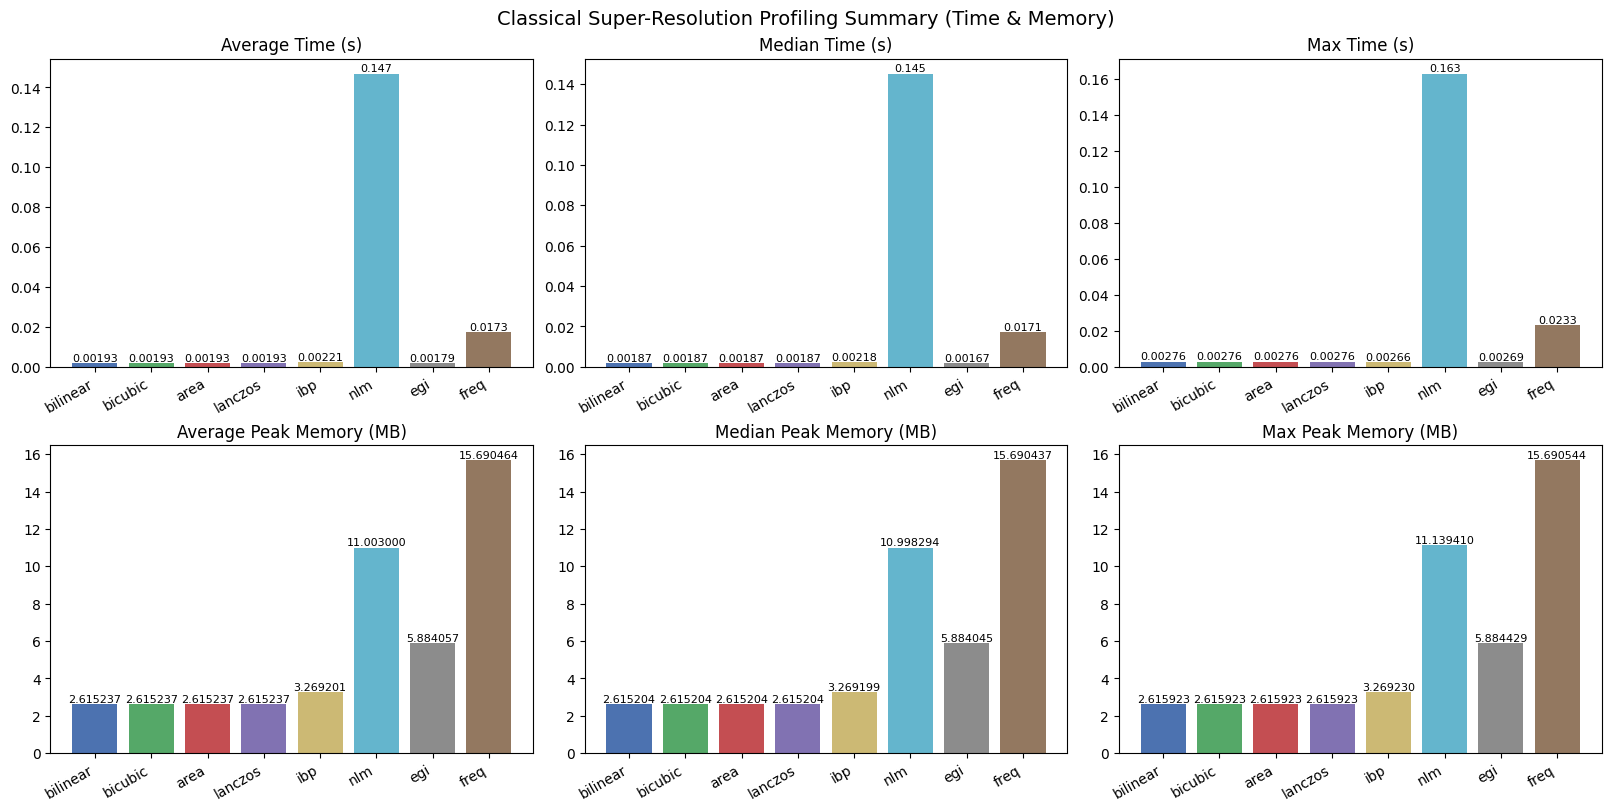

In [35]:
# Compute time and memory stats
(time_mean, time_median, time_max) = compute_summary_stats(time_stats_algorithms, algorithms)
(mem_mean_b, mem_median_b, mem_max_b) = compute_summary_stats(memory_stats_algorithms, algorithms)

if all(np.isnan(time_mean)) and all(np.isnan(mem_mean_b)):
    print('No profiling data collected yet.')
else:
    # Convert memory bytes to MB
    to_mb = lambda arr: [v / (1024**2) if not np.isnan(v) else v for v in arr]
    mem_mean = to_mb(mem_mean_b)
    mem_median = to_mb(mem_median_b)
    mem_max = to_mb(mem_max_b)

    stat_groups = [
        (time_mean,   'Average Time (s)'),
        (time_median, 'Median Time (s)'),
        (time_max,    'Max Time (s)'),
        (mem_mean,    'Average Peak Memory (MB)'),
        (mem_median,  'Median Peak Memory (MB)'),
        (mem_max,     'Max Peak Memory (MB)'),
    ]
    formats = ['{:.3g}', '{:.3g}', '{:.3g}', '{:.6f}', '{:.6f}', '{:.6f}']
    plot_six_panel(
        stat_groups,
        algorithms,
        colors,
        'Classical Super-Resolution Profiling Summary (Time & Memory)',
        RESULTS_DIR / 'time_memory_summary.png',
        formats
    )

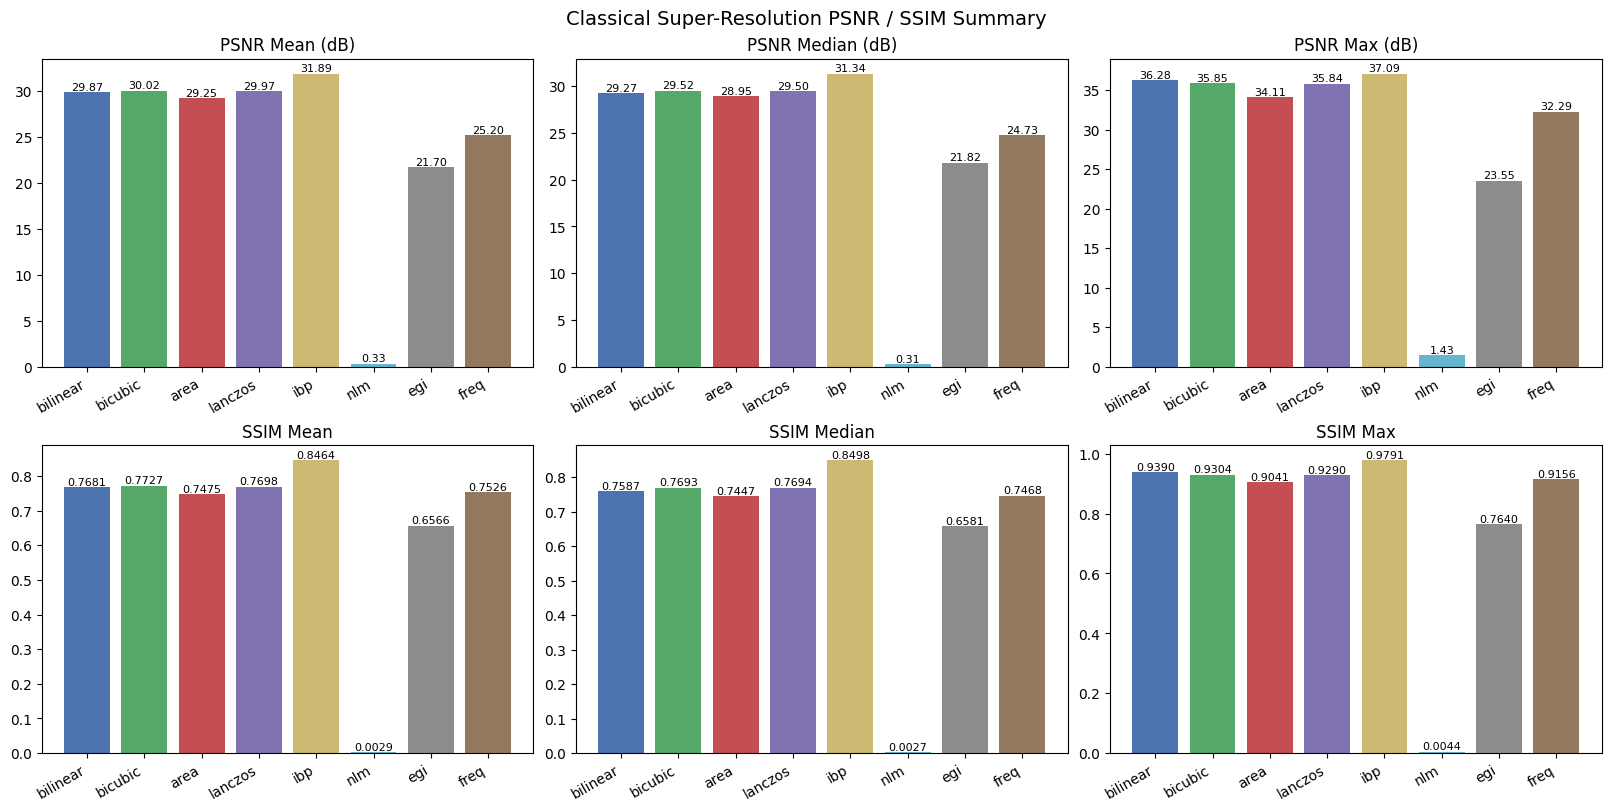

In [32]:
# PSNR / SSIM summary
psnr_summary = {
    'bilinear': psnr_stats['bilinear'],
    'bicubic': psnr_stats['bicubic'],
    'area': psnr_stats['area'],
    'lanczos': psnr_stats['lanczos'],
    'ibp': psnr_ibp_list,
    'nlm': psnr_nlm_list,
    'egi': psnr_egi_list,
    'freq': psnr_freq_list,
}
ssim_summary = {
    'bilinear': ssim_stats['bilinear'],
    'bicubic': ssim_stats['bicubic'],
    'area': ssim_stats['area'],
    'lanczos': ssim_stats['lanczos'],
    'ibp': ssim_ibp_list,
    'nlm': ssim_nlm_list,
    'egi': ssim_egi_list,
    'freq': ssim_freq_list,
}

(psnr_mean, psnr_median, psnr_max) = compute_summary_stats(psnr_summary, algorithms)
(ssim_mean, ssim_median, ssim_max) = compute_summary_stats(ssim_summary, algorithms)

stat_groups_metrics = [
    (psnr_mean,   'PSNR Mean (dB)'),
    (psnr_median, 'PSNR Median (dB)'),
    (psnr_max,    'PSNR Max (dB)'),
    (ssim_mean,   'SSIM Mean'),
    (ssim_median, 'SSIM Median'),
    (ssim_max,    'SSIM Max'),
]
formats_metrics = ['{:.2f}', '{:.2f}', '{:.2f}', '{:.4f}', '{:.4f}', '{:.4f}']
plot_six_panel(
    stat_groups_metrics,
    algorithms,
    colors,
    'Classical Super-Resolution PSNR / SSIM Summary',
    RESULTS_DIR / 'psnr_ssim_summary.png',
    formats_metrics
)

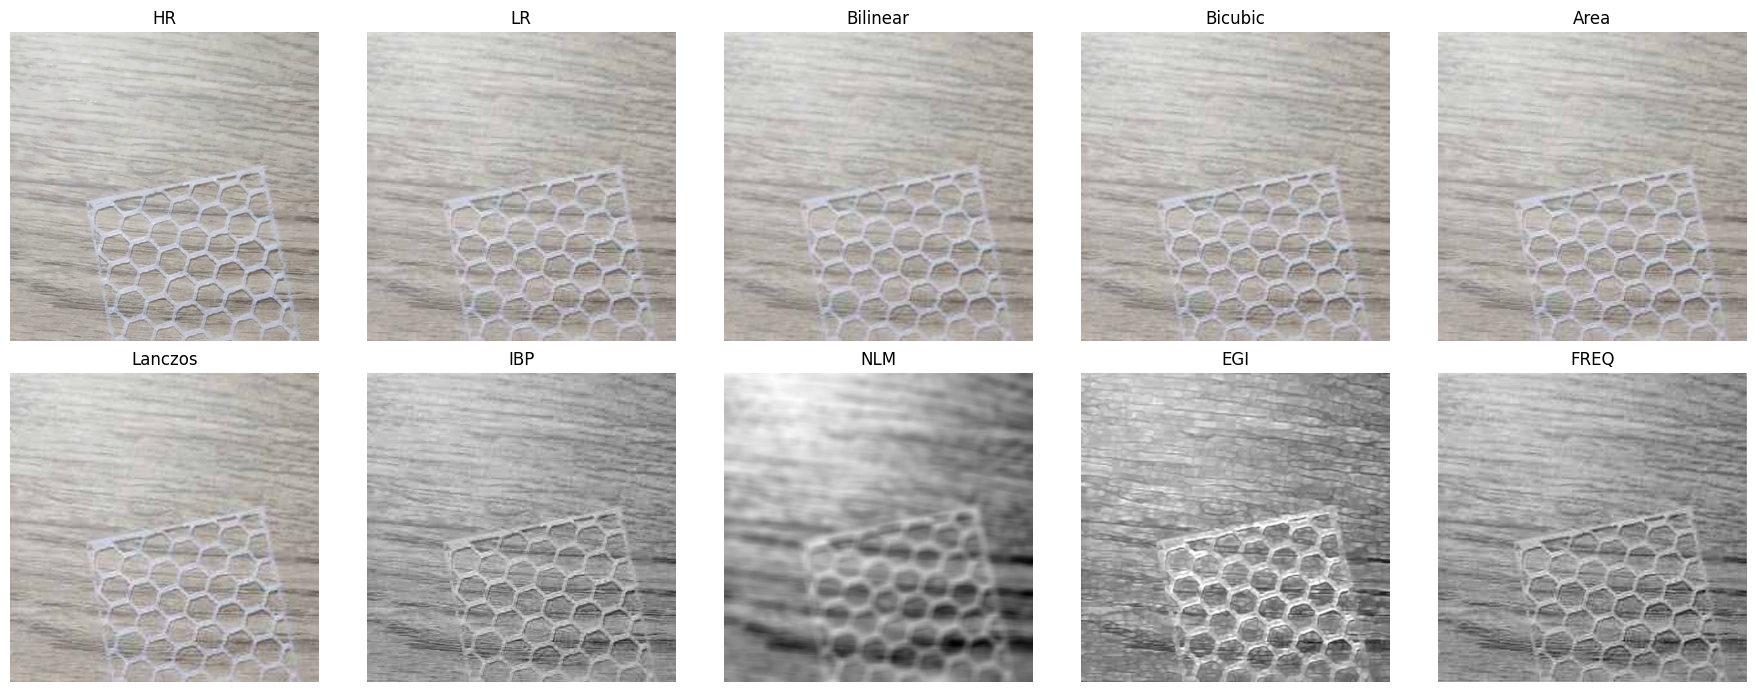

In [36]:
hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

def to_display(img):
    if img.ndim == 2:
        return img if img.dtype != np.float32 else np.clip(img,0,1)
    return img

images = [
    ('HR', hr_img_v),
    ('LR', lr_img_v),
    ('Bilinear', bilinear_v),
    ('Bicubic', bicubic_v),
    ('Area', area_v),
    ('Lanczos', lanczos_v),
    ('IBP', ibp_v),
    ('NLM', nlm_v if nlm_v.ndim==3 else nlm_v),
    ('EGI', egi_v),
    ('FREQ', freq_v),
]

plt.figure(figsize=(18,7))

for i, (title, img) in enumerate(images, start=1):
    plt.subplot(2,5,i)
    cmap = 'gray' if img.ndim==2 else None
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
out_grid = RESULTS_DIR / 'super_resolution_example.png'
plt.savefig(out_grid, dpi=150)

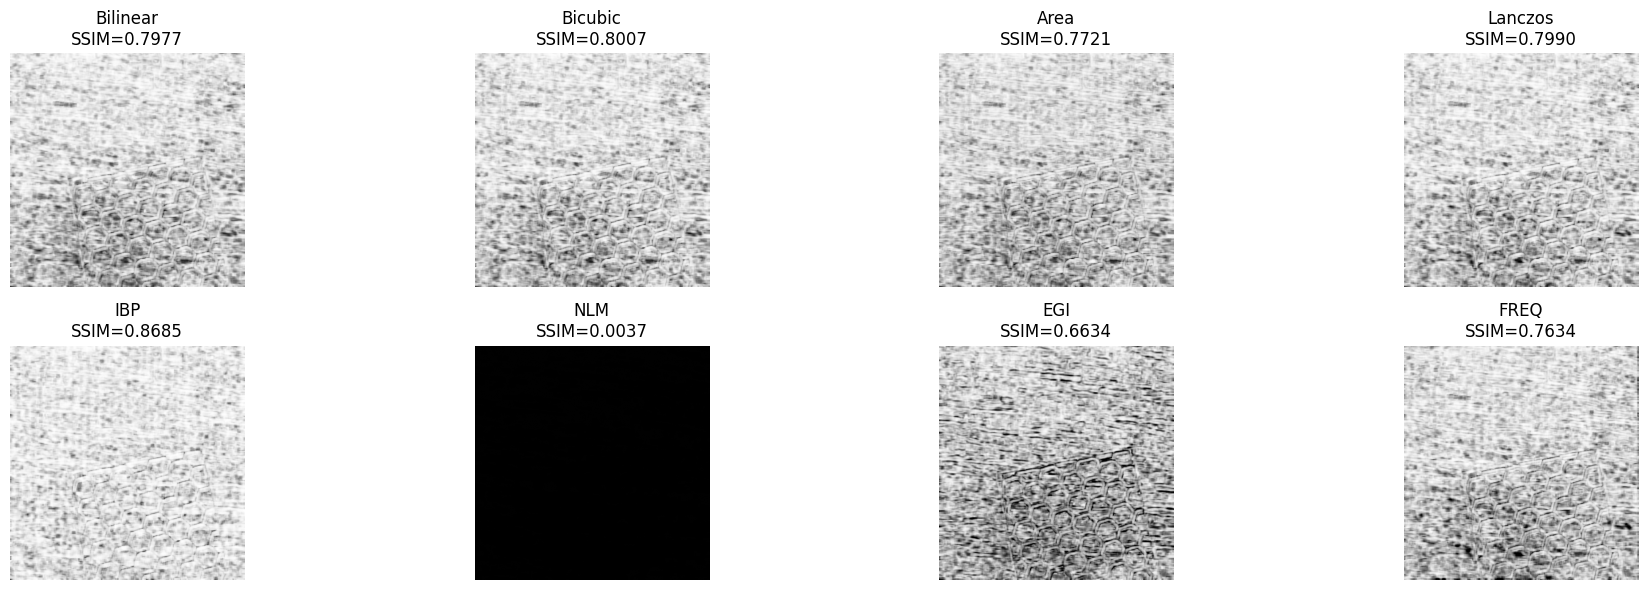

In [41]:
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img

hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

# Lista completa de pares (nombre, HR, SR) en el orden requerido
pairs = [
    ('Bilinear', to_gray(hr_img_v), to_gray(bilinear_v)),
    ('Bicubic',  to_gray(hr_img_v), to_gray(bicubic_v)),
    ('Area',     to_gray(hr_img_v), to_gray(area_v)),
    ('Lanczos',  to_gray(hr_img_v), to_gray(lanczos_v)),
    ('IBP',      hr_g_v, ibp_v),
    ('NLM',      hr_v, nlm_v if nlm_v.ndim==2 else cv2.cvtColor(nlm_v, cv2.COLOR_RGB2GRAY)),
    ('EGI',      hr_egi_v, egi_v),
    ('FREQ',     hr_freq_v, freq_v),
]

ssim_maps = []
titles = []
for name, hr_g, sr_g in pairs:
    data_range = 255 if hr_g.dtype != np.float32 else 1.0
    val, ssim_map = ssim(hr_g, sr_g, data_range=data_range, full=True)
    ssim_maps.append((ssim_map, val))
    titles.append(name)

plt.figure(figsize=(20,6))
for i, ((ssim_map, val), name) in enumerate(zip(ssim_maps, titles), start=1):
    plt.subplot(2,4,i)
    plt.imshow(ssim_map, cmap='gray', vmin=0, vmax=1)
    plt.title(f"{name}\nSSIM={val:.4f}")
    plt.axis('off')
plt.tight_layout()
out_diff = RESULTS_DIR / 'ssim_similarity_maps.png'
plt.savefig(out_diff, dpi=150)